
--- First 5 Rows ---
        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867  

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year      

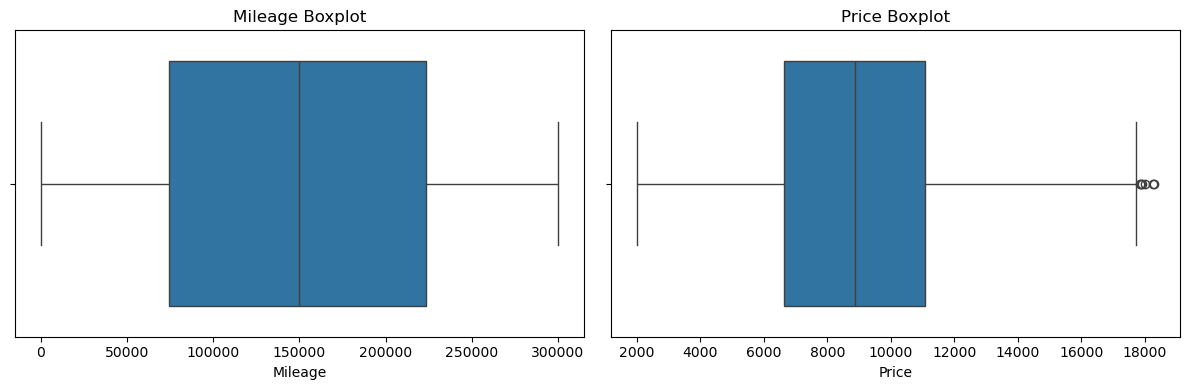


--- Numeric Correlation with Price ---
Price          1.000000
Year           0.663036
Engine_Size    0.357403
Owner_Count    0.002656
Doors          0.000511
Mileage       -0.551227
Name: Price, dtype: float64
Correlation ratio (eta) between Price and Brand: 0.04
Correlation ratio (eta) between Price and Model: 0.05
Correlation ratio (eta) between Price and Fuel_Type: 0.26
Correlation ratio (eta) between Price and Transmission: 0.25


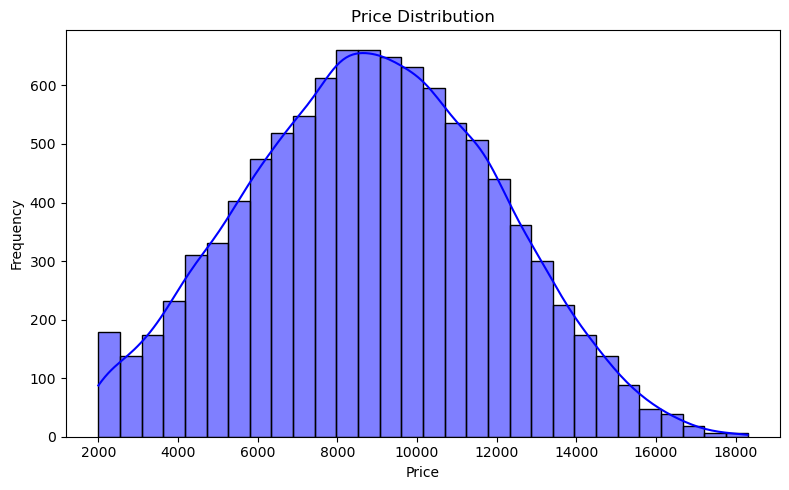

Mean Price: 8852.9644
Median Price: 8858.5


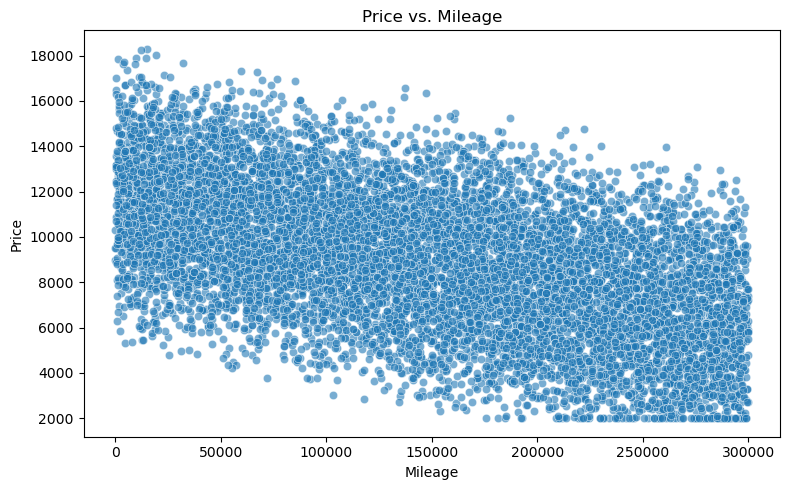


Sample Mean: 8852.96
95% Confidence Interval for Price: [8791.95, 8913.98]

t-test comparing Electric and Petrol Cars:
t-statistic: 23.24, p-value: 0.00


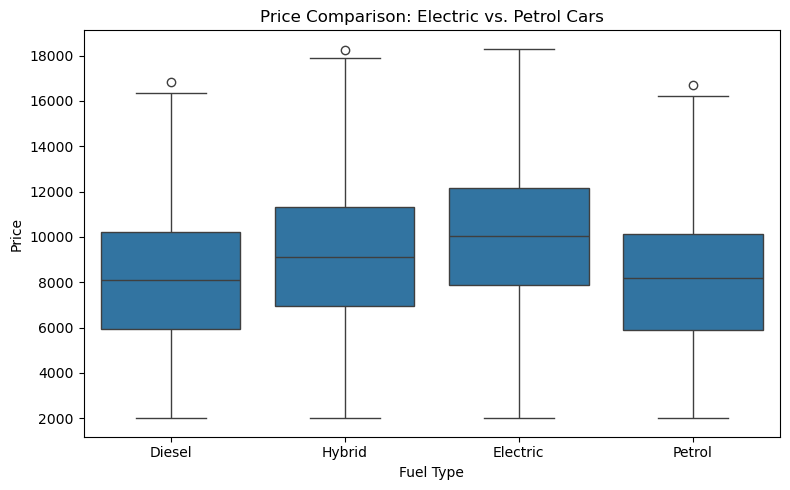


Linear Regression Model - Mean Squared Error on Test Set: 4258241.90


In [2]:
# =============================================================================
# Final Car Price Analysis and Modeling Code
# =============================================================================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# 1. Load and Inspect Data
# -----------------------------


data = pd.read_csv("car_price_dataset.csv")

# Show basic info and check for missing values
print("\n--- First 5 Rows ---")
print(data.head())

print("\n--- Dataset Info ---")
print(data.info())

print("\n--- Summary Statistics ---")
print(data.describe())

print("\n--- Missing Values ---")
print(data.isnull().sum())


# -----------------------------
# 2. Exploratory Data Analysis (EDA)
# -----------------------------


# Plot boxplots for Mileage and Price to inspect outliers
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=data["Mileage"])
plt.title("Mileage Boxplot")
plt.xlabel("Mileage")
plt.subplot(1, 2, 2)
sns.boxplot(x=data["Price"])
plt.title("Price Boxplot")
plt.xlabel("Price")
plt.tight_layout()
plt.show()

# Compute correlations for numeric variables with Price
num_cols = data.select_dtypes(include=[np.number])
corr_matrix = num_cols.corr()
print("\n--- Numeric Correlation with Price ---")
print(corr_matrix["Price"].sort_values(ascending=False))


# Function to compute the correlation ratio (eta) for categorical variables
def correlation_ratio(categories, measurements):
    # Factorize the categories to numeric values
    fcat, _ = pd.factorize(np.array(categories))
    categories_unique = np.unique(fcat)
    y_avg = np.nanmean(measurements)
    
    ss_between = 0
    ss_total = np.nansum((measurements - y_avg) ** 2)
    for cat in categories_unique:
        cat_measures = measurements[fcat == cat]
        ss_between += len(cat_measures) * (np.nanmean(cat_measures) - y_avg) ** 2
    return 0 if ss_total == 0 else np.sqrt(ss_between / ss_total)
    

# Calculate and print correlation ratio for selected categorical features
categorical_cols = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
for col in categorical_cols:
    eta = correlation_ratio(data[col], data['Price'])
    print(f"Correlation ratio (eta) between Price and {col}: {eta:.2f}")
    

# Plot Price distribution and one scatter plot for a glimpse into relationships
plt.figure(figsize=(8, 5))
sns.histplot(data['Price'], bins=30, kde=True, color="blue")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Calculate the mean and median for Price 
mean_price = data['Price'].mean()
median_price = data['Price'].median()
print("Mean Price:" , mean_price)
print("Median Price:" , median_price)


plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='Mileage', y='Price', alpha=0.6)
plt.title("Price vs. Mileage")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.tight_layout()
plt.show()



# -----------------------------
# 3. Statistical Analysis
# -----------------------------


# Ensure Price is numeric and drop rows with invalid values
data["Price"] = pd.to_numeric(data["Price"], errors="coerce")
data = data.dropna(subset=["Price"])

# Compute a 95% Confidence Interval for Price
prices = data["Price"].values
n = len(prices)
sample_mean = np.mean(prices)
sample_std = np.std(prices, ddof=1)
se = sample_std / np.sqrt(n)
t_val = stats.t.ppf(0.975, df=n-1)
margin_of_error = t_val * se
ci_lower = sample_mean - margin_of_error
ci_upper = sample_mean + margin_of_error

print(f"\nSample Mean: {sample_mean:.2f}")
print(f"95% Confidence Interval for Price: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Compare car prices for Electric vs. Petrol using a t-test
electric_prices = data.loc[data["Fuel_Type"] == "Electric", "Price"]
petrol_prices = data.loc[data["Fuel_Type"] == "Petrol", "Price"]
t_stat, p_value = stats.ttest_ind(electric_prices, petrol_prices, alternative='greater', equal_var=False)
print(f"\nt-test comparing Electric and Petrol Cars:")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.2f}")

plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Fuel_Type', y='Price')
plt.title('Price Comparison: Electric vs. Petrol Cars')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


# -----------------------------
# 4. Building a Linear Regression Model
# -----------------------------


# Select features and target variable
features = ['Engine_Size', 'Mileage', 'Fuel_Type', 'Transmission']
target   = 'Price'

# Setting up a preprocessing and modeling pipeline.
# Categorical features (Fuel_Type, Transmission) are one-hot encoded.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['Fuel_Type', 'Transmission'])
    ],
    remainder='passthrough'  # Leaves numerical columns unchanged
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42
)

# Fit the model and evaluate performance
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\nLinear Regression Model - Mean Squared Error on Test Set: {mse:.2f}")